###Importing Libraries, Modules and Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

###Importing Dataset MNIST Dataset

In [ ]:
from tensorflow.keras.datasets import mnist

###Building Generator for GAN

The Model Architecture of LSGAN is as shown below

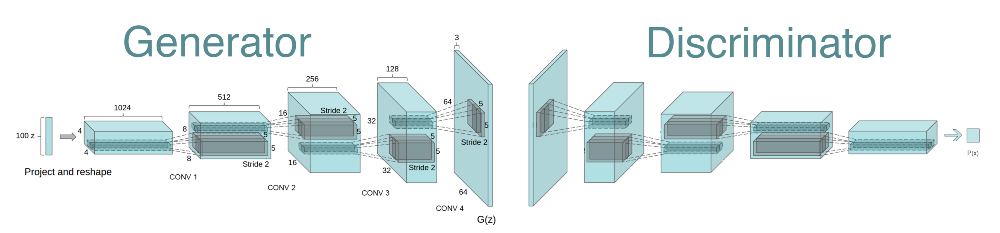

Example Architecture of layers

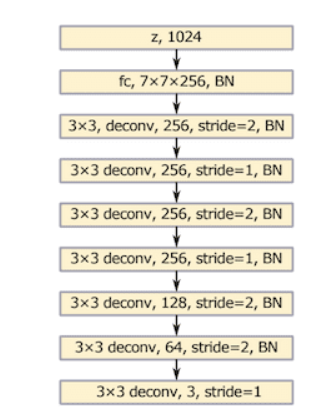

In [ ]:
"""
Build a Generator Model 
Stack of BN-ReLU-Conv2DTranpose to generate fake images. Output activation is sigmoid. Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size (int): Target size of one side 
            (assuming square image)
        activation (string): Name of output activation layer

    Returns:
        Model: Generator Model
"""

def Generator_Model(inputs, image_size, activation='sigmoid'):
    
    # // operator gives the floor value in int format
    image_resize = image_size // 4

    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    # default input is just 100-dim noise (z-code)
    x = inputs

    # As we can observe by above figure that first of all we have to project and reshape the input 
    # Passing the Noise vector to the first layer i.e. Dense Layer having number of nodes = 7*7*128
    x = Dense(image_resize * image_resize * layer_filters[0])(x)

    # Output of first layer will be (7*7*128, 1) Now this will be Reshaped to (7,7,128) this will be now fed into CONV blocks 
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    # Applying Activation Fucntion for the Output
    if activation is not None:
        x = Activation(activation)(x)

    # generator output is the synthesized image x
    return Model(inputs, x, name='generator')

###Building Discriminator for GAN

Example Architecture of Layers

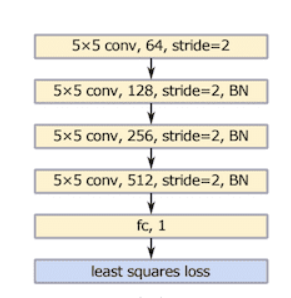

In [ ]:
"""
Build a Discriminator Model
Stack of LeakyReLU-Conv2D to discriminate real from fake The network does not converge with BN so it is not used here 

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        activation (string): Name of output activation layer
                    
    Returns:
        Model: Discriminator Model
"""

def Discriminator_Model(inputs, activation='sigmoid'):
    
    # Defining Parameters
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2

        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = Flatten()(x)

    # default output is probability that the image is real
    outputs = Dense(1)(x)

    if activation is not None:
        print(activation)
        outputs = Activation(activation)(outputs)

    return Model(inputs, outputs, name='discriminator')

###Building Training Function for GAN

This function is used for saving the Images sampled during the Training

In [ ]:
"""
Generate fake images and plot them For visualization purposes, generate fake images then plot them in a square grid

     Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

"""

def plot_images(generator, noise_input,  images_dir, show=False, step=0, model_name="gan"):
    
    filename = os.path.join(images_dir, "%05d.png" % step)

    # Number of Rows in the sampled images because we will generate 16 images of different Digits for each Step called
    rows = int(math.sqrt(noise_input.shape[0]))

    # Noise input is a collection of 16 different noise vectors
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]

    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

Here we are defining the function for Training process of Generator and Discriminator

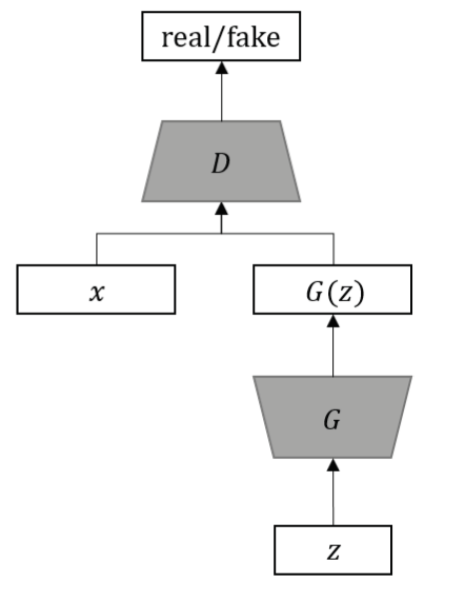

In [ ]:
"""
Train the Discriminator and Adversarial Networks
Alternately train Discriminator and Adversarial networks by batch. Discriminator is trained first with properly real and fake images.
Adversarial is trained next with fake images pretending to be real Generate sample images per save_interval.

     Arguments
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters

"""

def train(models, x_train, params, image_dir):

    # the GAN models
    generator, discriminator, adversarial = models

    # network parameters
    batch_size, latent_size, train_steps, model_name = params

    # the generator image is saved every 500 steps
    save_interval = 500

    # noise vector to see how the generator output evolves during training
    # it is a collection of 16 noise vectors for producing 16 different images
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])

    # number of elements in train dataset
    train_size = x_train.shape[0]

    for i in range(train_steps):

        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]

        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])

        # generate fake images
        fake_images = generator.predict(noise)

        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])

        # fake images label is 0.0
        y[batch_size:, :] = 0.0

        # train discriminator network, save the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0
        # since the discriminator weights are frozen in adversarial network only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])

        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])

        # train the adversarial network note that unlike in discriminator training, we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial for classification save the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)

        if (i % 100 == 0):
            print(log)

        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator, noise_input=noise_input, show=False, step=(i + 1), model_name=model_name, images_dir=image_dir)
   
    # save the model after training the generator the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

###Load the Dataset

In [ ]:
# load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "lsgan_mnist"

11493376/11490434 [==============================] - 0s 0us/step


###Defining the Hyperparameters

In [ ]:
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
input_shape = (image_size, image_size, 1)
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 40000

In [ ]:
# build DISCRIMINATOR Model
inputs = Input(shape=input_shape, name='discriminator_input')
discriminator = Discriminator_Model(inputs, activation=None)


# we are using RMSprop optimizer as discriminator easily converges with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)

# LSGAN uses MSE loss
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

In [ ]:
# build GENERATOR Model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')

generator = Generator_Model(inputs, image_size)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       51

In [ ]:
# build ADVERSARIAL Model = generator + discriminator
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)

# freeze the weights of discriminator during adversarial training
discriminator.trainable = False

adversarial = Model(inputs, discriminator(generator(inputs)), name=model_name)

# LSGAN uses MSE loss 
adversarial.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
adversarial.summary()

Model: "lsgan_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [ ]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, model_name)

# directory where we have to save the sampled images
image_dir = "/content/drive/MyDrive/Colab Notebooks/GAN/LSGAN Implementation/sampled_images"

train(models, x_train, params, image_dir)

0: [discriminator loss: 0.498329, acc: 0.500000] [adversarial loss: 0.167088, acc: 1.000000]
100: [discriminator loss: 0.018014, acc: 1.000000] [adversarial loss: 0.023628, acc: 1.000000]
200: [discriminator loss: 0.008725, acc: 1.000000] [adversarial loss: 0.020963, acc: 1.000000]
300: [discriminator loss: 0.008190, acc: 1.000000] [adversarial loss: 0.003430, acc: 1.000000]
400: [discriminator loss: 0.023715, acc: 1.000000] [adversarial loss: 0.202505, acc: 0.828125]
500: [discriminator loss: 0.009521, acc: 1.000000] [adversarial loss: 0.027184, acc: 1.000000]
600: [discriminator loss: 0.080304, acc: 1.000000] [adversarial loss: 1.573493, acc: 0.000000]
700: [discriminator loss: 0.012914, acc: 0.992188] [adversarial loss: 0.157271, acc: 1.000000]
800: [discriminator loss: 0.042933, acc: 0.992188] [adversarial loss: 0.741507, acc: 0.000000]
900: [discriminator loss: 0.032844, acc: 0.984375] [adversarial loss: 0.103816, acc: 0.968750]
1000: [discriminator loss: 0.106517, acc: 0.898438] 

###For Testing the Model

In [ ]:
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/GAN/LSGAN Implementation/test_sampled_images"
gen_path = "/content/drive/MyDrive/Colab Notebooks/GAN/LSGAN Implementation/lsgan_mnist.h5"

generator = load_model(gen_path, compile=False)

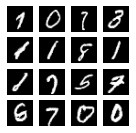

In [ ]:
noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

plot_images(generator, noise_input=noise_input, show=True, model_name="test_outputs", images_dir=test_image_dir)